# 旋转位置编码

## 参考资料
### 1 paper：https://arxiv.org/abs/2104.09864
### 2 作者知乎：https://zhuanlan.zhihu.com/p/359502624 ； https://kexue.fm/archives/8265
### 3 绝密伏击： https://zhuanlan.zhihu.com/p/675243992

# 1 相对位置实现

In [23]:
import torch
import math

def get_rotary_position_embedding(seq_len, dim):
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
    div_term = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
    pe = torch.zeros(seq_len, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

In [24]:
seq_len=5
dim=10
rope=get_rotary_position_embedding(seq_len, dim)
rope

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  1.5783e-01,  9.8747e-01,  2.5116e-02,
          9.9968e-01,  3.9811e-03,  9.9999e-01,  6.3096e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  3.1170e-01,  9.5018e-01,  5.0217e-02,
          9.9874e-01,  7.9621e-03,  9.9997e-01,  1.2619e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  4.5775e-01,  8.8908e-01,  7.5285e-02,
          9.9716e-01,  1.1943e-02,  9.9993e-01,  1.8929e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  5.9234e-01,  8.0569e-01,  1.0031e-01,
          9.9496e-01,  1.5924e-02,  9.9987e-01,  2.5238e-03,  1.0000e+00]])

In [5]:
def apply_rotary_position_embedding(x, rope):
    # 分离奇数和偶数索引
    x1 = x[..., ::2]  # 偶数索引
    x2 = x[..., 1::2]  # 奇数索引

    # 从rope中获取相应的cosine和sine部分
    cos_pos = rope[:, 0::2].repeat((x.size(0), x.size(1), 1, 1))  # 偶数索引
    sin_pos = rope[:, 1::2].repeat((x.size(0), x.size(1), 1, 1))  # 奇数索引

    # 应用旋转位置编码
    return torch.cat([x1 * cos_pos - x2 * sin_pos, x2 * cos_pos + x1 * sin_pos], dim=-1)

In [6]:
x=torch.rand(16,2,5,10)
apply_rotary_position_embedding(x, rope).shape

torch.Size([16, 2, 5, 10])

# 2 相对位置随位置衰减

In [25]:
import torch
import math
import matplotlib.pyplot as plt

# 生成旋转位置编码
def get_rotary_position_embedding(seq_len, dim):
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
    div_term = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
    pe = torch.zeros(seq_len, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# 计算并绘制点积随相对位置变化的曲线
def plot_dot_product_vs_distance(rope, reference_pos=0, title="Dot Product vs. Relative Distance"):
    # 参考位置编码
    ref_pe = rope[reference_pos]
    
    # 相对距离和对应的点积值
    distances = []
    dot_products = []
    
    for pos in range(len(rope)):
        if pos != reference_pos:
            distance = pos #- reference_pos
            dot_product = torch.dot(ref_pe, rope[pos]).item()
            distances.append(distance)
            dot_products.append(dot_product)

    # 绘制点积随距离变化的曲线
    plt.figure(figsize=(10, 6))
    plt.plot(distances, dot_products, marker='o')
    plt.title(title)
    plt.xlabel('Relative Distance from Position ' + str(reference_pos))
    plt.ylabel('Dot Product Value')
    plt.grid(True)
    plt.show()

# 设置参数
seq_length = 200  # 序列长度
embedding_dim = 128  # 嵌入维度

# 生成旋转位置编码
rope = get_rotary_position_embedding(seq_length, embedding_dim)



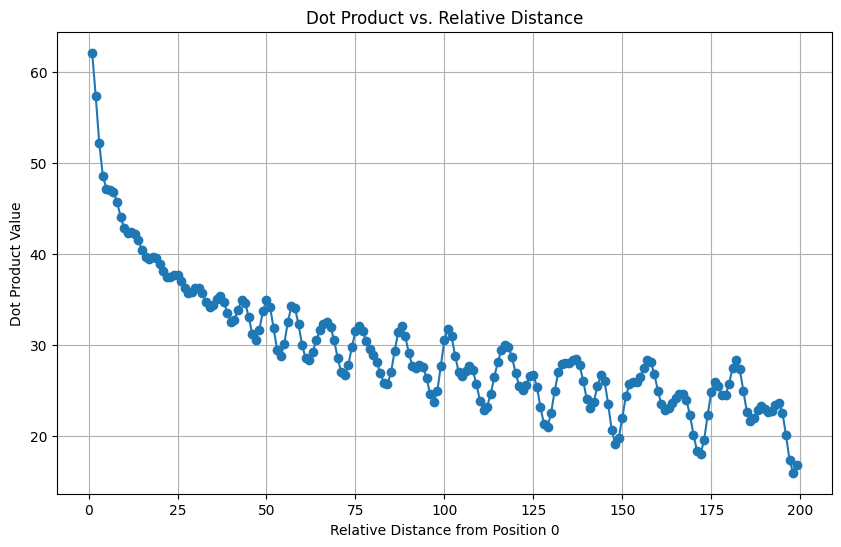

In [26]:
# 绘制点积随相对位置变化的曲线
plot_dot_product_vs_distance(rope, reference_pos=0)

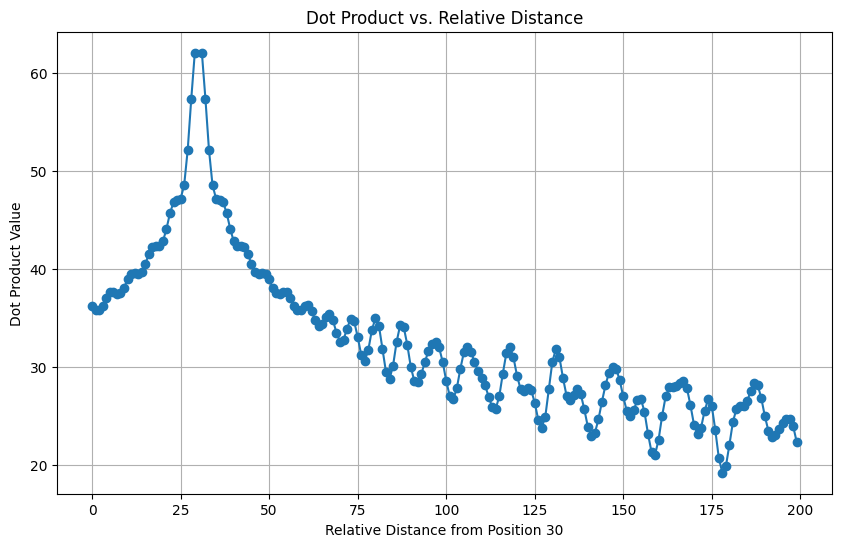

In [28]:
# 绘制点积随相对位置变化的曲线
plot_dot_product_vs_distance(rope, reference_pos=30)# q 30  k 0

In [7]:
class RotaryPositionAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(RotaryPositionAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.q_proj = torch.nn.Linear(embed_dim, embed_dim)
        self.k_proj = torch.nn.Linear(embed_dim, embed_dim)
        self.v_proj = torch.nn.Linear(embed_dim, embed_dim)
        self.out_proj = torch.nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, _ = query.size()
        q = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 生成并应用旋转位置编码
        rope = get_rotary_position_embedding(seq_len, self.head_dim)
        q = apply_rotary_position_embedding(q, rope)
        k = apply_rotary_position_embedding(k, rope)
        
        # 计算注意力权重
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_weights, dim=-1)
        
        # 应用注意力权重
        attn_output = torch.matmul(attn_weights, v).transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        output = self.out_proj(attn_output)
        return output

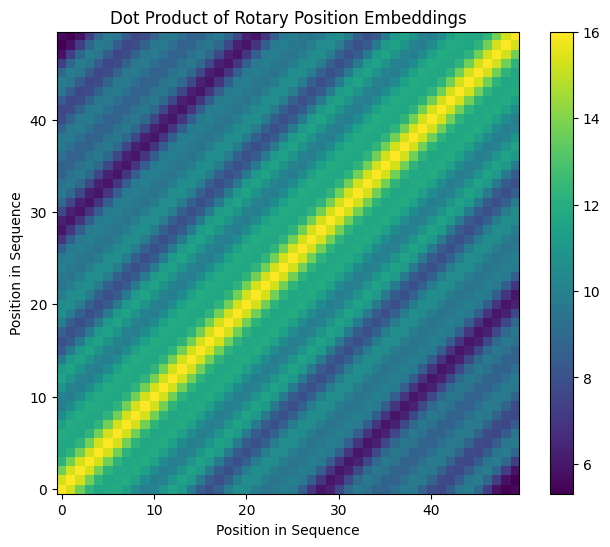

In [8]:
import torch
import math
import matplotlib.pyplot as plt

# 生成旋转位置编码
def get_rotary_position_embedding(seq_len, dim):
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
    div_term = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
    pe = torch.zeros(seq_len, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# 计算并绘制点积矩阵
def plot_dot_product_matrix(rope, title="Dot Product Matrix"):
    dot_products = torch.matmul(rope, rope.t())
    plt.figure(figsize=(8, 6))
    plt.imshow(dot_products, cmap='viridis', origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Position in Sequence')
    plt.ylabel('Position in Sequence')
    plt.show()

# 设置参数
seq_length = 50  # 序列长度
embedding_dim = 32  # 嵌入维度

# 生成旋转位置编码
rope = get_rotary_position_embedding(seq_length, embedding_dim)

# 绘制点积矩阵
plot_dot_product_matrix(rope, "Dot Product of Rotary Position Embeddings")

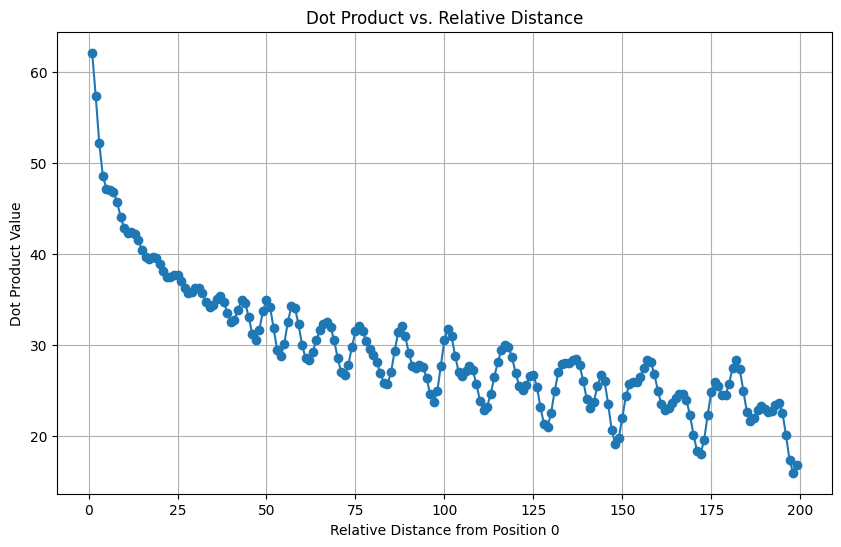

In [15]:
import torch
import math
import matplotlib.pyplot as plt

# 生成旋转位置编码
def get_rotary_position_embedding(seq_len, dim):
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
    div_term = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
    pe = torch.zeros(seq_len, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# 计算并绘制点积随相对位置变化的曲线
def plot_dot_product_vs_distance(rope, reference_pos=0, title="Dot Product vs. Relative Distance"):
    # 参考位置编码
    ref_pe = rope[reference_pos]
    
    # 相对距离和对应的点积值
    distances = []
    dot_products = []
    
    for pos in range(len(rope)):
        if pos != reference_pos:
            distance = pos - reference_pos
            dot_product = torch.dot(ref_pe, rope[pos]).item()
            distances.append(distance)
            dot_products.append(dot_product)

    # 绘制点积随距离变化的曲线
    plt.figure(figsize=(10, 6))
    plt.plot(distances, dot_products, marker='o')
    plt.title(title)
    plt.xlabel('Relative Distance from Position ' + str(reference_pos))
    plt.ylabel('Dot Product Value')
    plt.grid(True)
    plt.show()

# 设置参数
seq_length = 200  # 序列长度
embedding_dim = 128  # 嵌入维度

# 生成旋转位置编码
rope = get_rotary_position_embedding(seq_length, embedding_dim)

# 绘制点积随相对位置变化的曲线
plot_dot_product_vs_distance(rope, reference_pos=0)

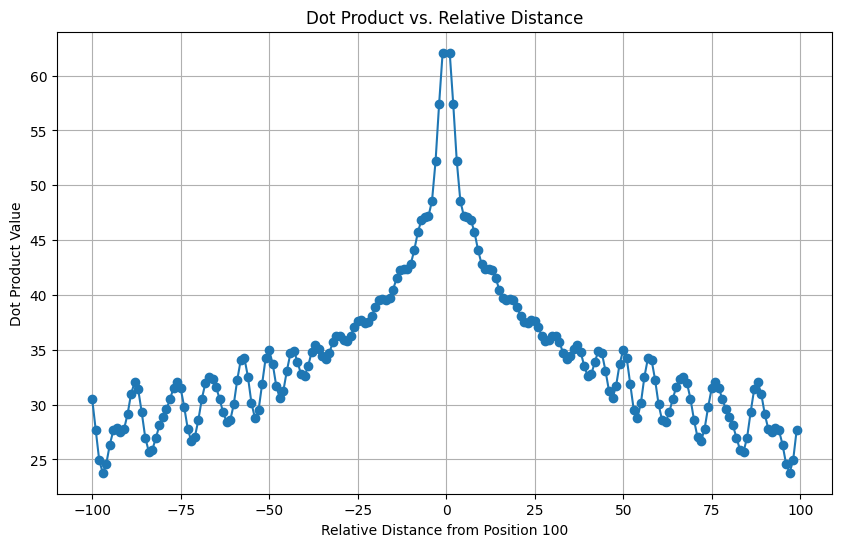

In [16]:
# 绘制点积随相对位置变化的曲线
plot_dot_product_vs_distance(rope, reference_pos=100)